In [ ]:
import numpy as np


# http://karpathy.github.io/2016/05/31/rl/
def preprocess_image(img):
  # shape = 210x160x3
  img = img[35:195] # crop -> 160 x 160 x 3
  img = img[::2,::2,0] # downsample by factor of 2 -> 80 x 80
  img[img == 144] = 0 # erase background (background type 1)
  img[img == 109] = 0 # erase background (background type 2)
  img[img != 0] = 1 # everything else (paddles, ball) just set to 1
  return img




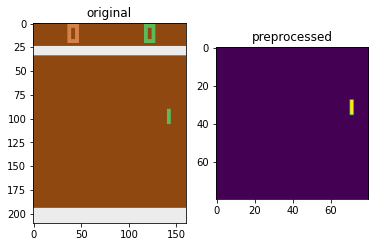

(80, 80)


In [ ]:
import matplotlib.pyplot as plt
from random import randint
import gym

env = gym.make('PongNoFrameskip-v4')
frame = env.reset()
frame = env.step(0)
# neki random frame prikazi
for i in range(randint(10, 30)):
  frame, r, d, _ = env.step(randint(0, env.action_space.n - 1))
  if d:
    env.reset()
    frame, r, d, _ = env.step(0) # Fire

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original')

plt.subplot(1,2,2)
plt.title('preprocessed')
preprocessed = preprocess_image(frame)
plt.imshow(preprocessed)

plt.show()

print(preprocessed.shape)

In [ ]:
import torch

# https://github.com/colinskow/move37/blob/master/dqn/lib/wrappers.py
class FireResetWrapper(gym.Wrapper):
    def __init__(self, env=None):
        """For environments where the user needs to press FIRE for the game to start."""
        super(FireResetWrapper, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

  
class SkipAndPoolWrapper(gym.Wrapper):

    def __init__(self, env, skip=4, pooling_function='max'):
        super(SkipAndPoolWrapper, self).__init__(env)
        if pooling_function == 'max':
            self.pool = np.max
        elif pooling_function == 'mean':
            self.pool = np.mean
        else:
            raise ValueError('Only accepting "max" and "mean" pooling')

        self.buff = np.zeros((skip, *env.observation_space.shape))
    
    def step(self, act):
        total_reward = 0.0
        done = False
        processed_before_done = 0
        for i in range(self.buff.shape[0]):
            obs, rw, done, info = self.env.step(act)
            total_reward += rw
            self.buff[i] = obs
            processed_before_done += 1
            if done:
                break
        pooled_frame = self.pool(self.buff[:processed_before_done], axis=0)
        return pooled_frame, total_reward, done, info

class TorchWrapper(gym.Wrapper):
    
    def __init__(self, env=None, obs_dtype=torch.float32, reward_dtype=torch.float32):
        super(TorchWrapper, self).__init__(env)
        self.obs_dtype = obs_dtype
        self.reward_dtype = reward_dtype
    
    def reset(self):
        obs = self.env.reset()
        return torch.as_tensor(obs, dtype=self.obs_dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return torch.as_tensor(obs, dtype=self.obs_dtype), torch.as_tensor(reward, dtype=self.reward_dtype), done, info

class BufferedWrapper(gym.ObservationWrapper):

    def __init__(self, env, steps, dtype=np.float32):
        super(BufferedWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(steps, axis=0).reshape(steps, old_space.low.shape[0], old_space.low.shape[1]),
                                                old_space.high.repeat(steps, axis=0).reshape(steps, old_space.high.shape[0], old_space.high.shape[1]),
                                                dtype=dtype)
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())
    
    def observation(self, obs):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = obs
        return self.buffer

class PreprocessWrapper(gym.ObservationWrapper):

  def __init__(self, env=None):
    super(PreprocessWrapper, self).__init__(env)
    obs_space_old = self.observation_space
    old_shape = obs_space_old.shape
    self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(int((old_shape[0] - 50) / 2), int((old_shape[1]) / 2)))
    
  
  def observation(self, obs):
    return preprocess_image(obs)

wrapped_env = PreprocessWrapper(env)
print(wrapped_env.observation_space.shape)

img = wrapped_env.reset()
print(img.shape)
wrapped_env.step(0)
for i in range(randint(10, 30)):
  img, r, d, _ = wrapped_env.step(randint(0, env.action_space.n - 1))
  if d:
    wrapped_env.reset()
    img, r, d, _ = wrapped_env.step(0) # Fire


(80, 80)
(80, 80)


In [ ]:
def make_pong_env(name, use_skip=True):
  env = gym.make(name)
  if use_skip:
    env = SkipAndPoolWrapper(env)
  env = FireResetWrapper(env)
  env = PreprocessWrapper(env)
  env = BufferedWrapper(env, 4)
  env = TorchWrapper(env)
  return env

env = make_pong_env('PongNoFrameskip-v4')
obs = env.reset()
print(obs.shape)


torch.Size([4, 80, 80])


In [ ]:
import torch.nn as nn
import torch.optim as optim
import pdb

def train(env,
          actor,
          critic,
          value_opt,
          actor_opt,
          max_kl=0.01,
          epsilon=0.2,
          epochs=100,
          batch_size=50,
          gamma=0.99,
          lam=0.96,
          val_loss_coef=0.5,
          entropy_coeff=0.001,
          train_critic_iters=5,
          train_actor_iters=5):

    
    def rewards_and_advantages(rewards, obs, critic):
        #pdb.set_trace()
        n = len(rewards)
        adv_to_go = torch.zeros(n)
        rewards_to_go = torch.zeros(n)
        #vs = torch.zeros(n)
        #for i in range(n):
        #   vs[i] = critic(obs[i])
        with torch.no_grad():
          vs = critic(torch.stack(obs)).squeeze()

        for i in reversed(range(n)):
            not_last = i < (n - 1)
            rewards_to_go[i] = rewards[i]
            adv_to_go[i] = rewards[i] - vs[i]

            if not_last:
                #pdb.set_trace()
                adv_to_go[i] += gamma * vs[i + 1] + gamma * lam * adv_to_go[i + 1]
                rewards_to_go[i] += gamma * rewards_to_go[i + 1]
            
        return adv_to_go, rewards_to_go
    

    def loss_and_kl(obs, adv, actions, old_log_probs):
        log_probs, entropy = actor(obs, actions)
        log_ratio = log_probs - old_log_probs
        ratio = torch.exp(log_ratio)
        
        clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        loss = torch.mean(-torch.min(ratio * adv, clipped * adv)) - entropy_coeff * entropy.mean()

        kl = (torch.exp(log_probs) * log_ratio).mean()

        return loss, kl

    def train_epoch():
        obs_batch = []
        action_batch = []
        log_probs = []
        entropies = []
        rewards_batch = []
        advantages_batch = []
        returns_batch = []
        
        obs, done = env.reset(), False
        
        episode_rewards = []
        
        while True:
            
            obs_batch.append(obs)
            with torch.no_grad():
              act, log_prob, entrpy = actor.sample_action(obs.unsqueeze(0))

            obs, reward, done, _ = env.step(act + 2)

            action_batch.append(act)
            log_probs.append(log_prob)
            entropies.append(entrpy)
            episode_rewards.append(reward)

            if done:
                #pdb.set_trace()
                returns_batch.append(sum(episode_rewards))
                advantages, rewards = rewards_and_advantages(episode_rewards, obs_batch, critic)
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                rewards_batch.append(rewards)
                advantages_batch.append(advantages)

                obs, done = env.reset(), False
                episode_rewards = []
                if len(obs_batch) > batch_size:
                    break
        #pdb.set_trace()
        entropy = torch.stack(entropies)
        obs_tensor = torch.stack(obs_batch).data
        adv_tensor = torch.cat(advantages_batch).data
        reward_tensor = torch.cat(rewards_batch).data
        action_tensor = torch.as_tensor(action_batch).data
       
        log_probabilities = torch.stack(log_probs)
        old_log_probabilities = log_probabilities.detach() + 1e-8


        loss_clip, kl_old_new = torch.tensor(0.0), torch.tensor(0.0)
        print(f'Training policy (actor) for {train_actor_iters} iterations')
        for i in range(1, train_actor_iters + 1):
            actor_opt.zero_grad()

            loss_clip, kl = loss_and_kl(obs=obs_tensor, adv=adv_tensor, actions=action_tensor, old_log_probs=old_log_probabilities)
            if kl > 1.5 * max_kl:
                 print(f'Early stopping at iteration {i}, reached max KL')
                 break
            kl_old_new = kl
            loss_clip.backward()
            actor_opt.step()


        # provjeri za nan i inf?
        print(f'Training value function (critic) for {train_critic_iters} iterations')
        for _ in range(train_critic_iters):
            value_opt.zero_grad()
            value_loss = torch.mean((critic(obs_tensor) - reward_tensor) ** 2) * val_loss_coef
            value_loss.backward()
            value_opt.step()

        return loss_clip, value_loss, returns_batch, kl_old_new
    
    for i in range(1, epochs + 1):
        policy_loss, value_loss, returns, kl = train_epoch()
        print('Epoch: %3d \t Policy loss: %.3f \t Value loss: %.3f \t Avg Return: %.3f \t KL: %.3f'%
                (i, policy_loss, value_loss, torch.mean(torch.as_tensor(returns)), kl))
    return actor, critic



In [ ]:
from core import CategoricalActor, make_ann

def make_actor(n_actions, cnn_activation=nn.ReLU, ann_activation=nn.ReLU):
  conv_layers = []
  # conv1 : 80 x 80 -> 40 x 40
  conv_layers.append(nn.Conv2d(4, 8, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 40 x 40 -> 20 x 20
  conv_layers.append(nn.Conv2d(8, 16, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 20 x 20 -> 10 x 10
  conv_layers.append(nn.Conv2d(16, 32, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 10 x 10 -> 5 x 5
  conv_layers.append(nn.Conv2d(32, 64, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  conv_layers.append(nn.Flatten())

  return CategoricalActor(make_ann([64 * 5 * 5, 512, 256, 128, n_actions],
                          ann_activation,
                          conv_layers))

def make_critic(cnn_activation=nn.ReLU, ann_activation=nn.Tanh):
  conv_layers = []
  # conv1 : 80 x 80 -> 40 x 40
  conv_layers.append(nn.Conv2d(4, 8, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 40 x 40 -> 20 x 20
  conv_layers.append(nn.Conv2d(8, 16, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 20 x 20 -> 10 x 10
  conv_layers.append(nn.Conv2d(16, 32, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  # conv1 : 10 x 10 -> 5 x 5
  conv_layers.append(nn.Conv2d(32, 64, kernel_size=2, stride=2))
  conv_layers.append(cnn_activation())
  conv_layers.append(nn.Flatten())

  return make_ann([64 * 5 * 5, 512, 256, 128, 1], ann_activation, conv_layers)

def main(pong_env_name, use_skip=True, epochs=1000, batch_size=50):
  env = make_pong_env(pong_env_name, use_skip)
  # Pong ima action space velicine 6, ali 2 redundantne i 2 beskorisne akcije
  actor = make_actor(env.action_space.n - 4)
  critic = make_critic()

  opt_val = optim.SGD(actor.parameters(), lr=3e-4)
  opt_policy = optim.SGD(critic.parameters(), lr=3e-4)

  actor, critic = train(env, actor, critic, opt_val, opt_policy, epochs=epochs, batch_size=batch_size)

  return actor, critic


In [ ]:

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display


def test(env_name, actor, directory, episodes):
  actor.eval()
  display = Display(visible=0, size=(400, 300))
  display.start()
  env = gym.make(env_name)
  #env = gym.wrappers.Monitor(env, directory, video_callable=lambda id: True, force=True)
  env = SkipAndPoolWrapper(env)
  env = FireResetWrapper(env)
  env = PreprocessWrapper(env)
  env = BufferedWrapper(env, 4)
  env = TorchWrapper(env)
  

  #env = gym.wrappers.Monitor(env, directory, force=True)
  for _ in range(episodes):
    obs, done = env.reset(), False
    #env.render()
    while not done:

      with torch.no_grad():
        obs, _, done, _ = env.step(actor.sample_action(obs.unsqueeze(0))[0] + 2)
        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

  ipythondisplay.clear_output(wait=True)
  env.close()
  display.stop()
    

In [ ]:
actor, critic = main('PongNoFrameskip-v4', epochs=4000, batch_size=1000)


Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   1 	 Policy loss: -0.000 	 Value loss: 2.818 	 Avg Return: -21.000 	 KL: 0.000
Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   2 	 Policy loss: -0.000 	 Value loss: 2.073 	 Avg Return: -21.000 	 KL: 0.000
Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   3 	 Policy loss: -0.001 	 Value loss: 2.198 	 Avg Return: -20.500 	 KL: 0.000
Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   4 	 Policy loss: -0.001 	 Value loss: 2.664 	 Avg Return: -21.000 	 KL: 0.000
Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   5 	 Policy loss: -0.000 	 Value loss: 2.175 	 Avg Return: -21.000 	 KL: 0.000
Training policy (actor) for 5 iterations
Training value function (critic) for 5 iterations
Epoch:   6 	 Policy

In [ ]:
test('PongNoFrameskip-v4', actor, 'prob_dir', 1)